In [17]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches
from matplotlib import pylab
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, matthews_corrcoef, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load sequence data
sequence_data = pd.read_csv('Waltz_Data_Filtered')

training_data = sequence_data.drop(['Classification', 'Sequence'], axis = 1)
target_data = sequence_data['Classification']

In [3]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(training_data, target_data, test_size = 0.2, random_state = 0)

# Set the parameters by cross-validation
forest_parameters = [{'n_estimators': [10, 100, 1000], 'max_depth': [1, 10, 100, 1000]}]

classifier_forest = GridSearchCV(RandomForestClassifier(), forest_parameters, cv = 10, scoring='roc_auc')
classifier_forest.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 100, 1000], 'max_depth': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [4]:
# save grid search results to variables, for plotting
forest_n_estimators = list(classifier_forest.cv_results_['param_n_estimators'])
forest_max_depth = list(classifier_forest.cv_results_['param_max_depth'])
forest_results = classifier_forest.cv_results_['mean_test_score']

In [5]:
# separate out results for each gamma value
forest_max_depth_1_results = []
forest_max_depth_10_results = []
forest_max_depth_100_results = []
forest_max_depth_1000_results = []

lookup = {'1' : forest_max_depth_1_results,
          '10' : forest_max_depth_10_results,
          '100' : forest_max_depth_100_results,
          '1000' : forest_max_depth_1000_results
         }

for i in range(0, len(forest_max_depth)):
    max_depth_list = lookup[str(forest_max_depth[i])]
    max_depth_list.append(forest_results[i])

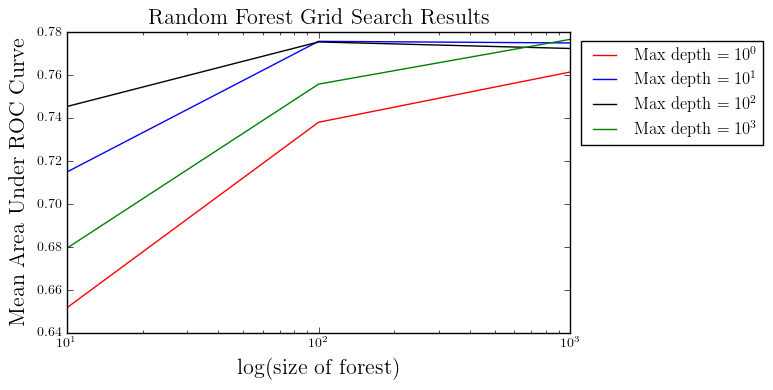

In [6]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cm'

plt.semilogx(forest_n_estimators[0:3], forest_max_depth_1_results, color = 'red')
plt.semilogx(forest_n_estimators[0:3], forest_max_depth_10_results, color = 'blue')
plt.semilogx(forest_n_estimators[0:3], forest_max_depth_100_results, color = 'black')
plt.semilogx(forest_n_estimators[0:3], forest_max_depth_1000_results, color = 'green')

ax = plt.gca()
ax.set_title('Random Forest Grid Search Results', fontsize = 16)
ax.set_xlabel(r'$\log($size of forest$)', fontsize = 16)
ax.set_ylabel('Mean Area Under ROC Curve', fontsize = 16)

forest_1 = mlines.Line2D([], [], linestyle = '-', color = 'red', label = r'Max depth $= 10^0$')
forest_10 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = r'Max depth $= 10^1$')
forest_100 = mlines.Line2D([], [], linestyle = '-', color = 'black', label = r'Max depth $= 10^2$')
forest_1000 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = r'Max depth $= 10^3$')
plt.legend(handles = [forest_1, forest_10, forest_100, forest_1000], loc = 'upper right', frameon = True, bbox_to_anchor=(1.4, 1))

plt.tight_layout()
plt.show()

In [7]:
# apply fitted SVM classifier with best hyperparameters to test data
y_score_pairs = classifier_forest.best_estimator_.predict_proba(X_test)

# create array of probability scores for each hexapeptide
y_score_pos = []
for pair in y_score_pairs:
    y_score_pos.append(pair[1])

In [8]:
# calculate values needed for ROC curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, y_score_pos)

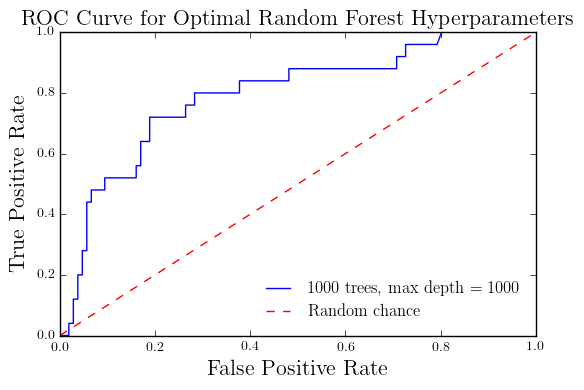

In [9]:
# plot ROC curve
plt.plot(false_pos_rate, true_pos_rate)
ax = plt.gca()
ax.set_title('ROC Curve for Optimal Random Forest Hyperparameters', fontsize = 16)
ax.set_xlabel('False Positive Rate', fontsize = 16)
ax.set_ylabel('True Positive Rate', fontsize = 16)

plt.plot(np.linspace(0, 1), np.linspace(0, 1), linestyle = '--', color = 'red')

ROC_curve = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = r'' + str(classifier_forest.best_estimator_.n_estimators) + ' trees, max depth $= ' + str(classifier_forest.best_estimator_.max_depth) + '$' )
rand_chance = mlines.Line2D([], [], linestyle = '--', color = 'red', label = r'Random chance')
plt.legend(handles = [ROC_curve, rand_chance], loc = 'lower right', frameon = False)

plt.tight_layout()
plt.show()

In [10]:
# find best probability threshold
ROC_line = list(zip(false_pos_rate, true_pos_rate))

# search for point on ROC line that is closest to point (0, 1)
best = (1, 0)
best_dist = 1
best_index = 0
for i in range(0, len(ROC_line)):
    new_dist = np.sqrt((0 - ROC_line[i][0]) + (1 - ROC_line[i][1]))
    if (new_dist < best_dist):
        best = ROC_line[i]
        best_index = i

# find best probability threshold
best_theshold = thresholds[best_index]
print('best probability threshold =', best_theshold)

best probability threshold = 0.16


In [11]:
y_test_predicted = []
for probability in y_score_pos:
    if (probability >= best_theshold):
        y_test_predicted.append(1)
    else:
        y_test_predicted.append(0)

In [12]:
matthews_corrcoef(y_test, y_test_predicted)

0.37528017168195349

In [13]:
matthews_corrcoef(y_test, classifier_forest.best_estimator_.predict(X_test))

0.10602965674853732

In [19]:
accuracy_score(y_test, classifier_forest.best_estimator_.predict(X_test))

0.80152671755725191